## Student Performance Dataset (UCI)

### Objetivo

Construir um **modelo baseline de classificação** para prever **aprovação** (`target_pass`) usando apenas variáveis socioeconômicas, comportamentais e contextuais.

Este notebook foca em:
- Preparação de dados (train/test split)
- Pipeline de pré-processamento (numéricas + categóricas)
- Treino de modelos clássicos
- Avaliação com métricas
- Interpretação simples do modelo
- Síntese final

---

### Definição do target

- `target_pass = 1` se `G3 >= 10` (aprovado)
- `target_pass = 0` se `G3 < 10` (reprovado)

### Observação importante (evitar vazamento)

Não usaremos `G1`, `G2`, `G3` como features, pois são notas e dominariam a previsão.


## Importação de bibliotecas e carregamento de dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

## 1. Carregamento dos dados

O CSV original usa `;` como separador.


In [3]:
DATA_PATH = "data/student-mat.csv"  # ajuste se necessário
df = pd.read_csv(DATA_PATH, sep=";")


In [4]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


## 2. Target e seleção de features

Criamos o target binário `target_pass`.

Em seguida definimos as features removendo:
- `G1`, `G2`, `G3` (notas)
- `target_pass` (target)

Assim, o baseline aprende apenas com contexto socioeconômico, familiar e comportamental.


In [5]:
df["target_pass"] = (df["G3"] >= 10).astype(int)

TARGET_COL = "target_pass"
DROP_LEAKY = ["G1", "G2", "G3"]

X = df.drop(columns=[TARGET_COL] + DROP_LEAKY)
y = df[TARGET_COL]

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))


X shape: (395, 30)
y distribution:
 target_pass
1    0.670886
0    0.329114
Name: proportion, dtype: float64


## 3. Train/Test Split

Vamos separar em treino e teste com estratificação no target para manter a proporção de classes.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train y mean:", y_train.mean(), "Test y mean:", y_test.mean())


Train: (316, 30) Test: (79, 30)
Train y mean: 0.6708860759493671 Test y mean: 0.6708860759493671


## 4. Pipeline de pré-processamento

Como temos colunas numéricas e categóricas, faremos:

- Numéricas:
  - imputação (mediana)
  - padronização (StandardScaler)

- Categóricas:
  - imputação (mais frequente)
  - One-Hot Encoding

Tudo isso dentro de um `ColumnTransformer` para garantir reprodutibilidade.


In [7]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

In [8]:
numeric_features

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences']

In [9]:
categorical_features

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [10]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## 5. Modelos baseline

Vamos treinar dois modelos clássicos:

1. **Logistic Regression**
   - baseline interpretável
   - bom para entender direção dos efeitos

2. **Random Forest**
   - baseline robusto
   - aprende não-linearidades
   - bom para comparar com a regressão logística

Vamos avaliar ambos no conjunto de teste.


In [11]:
log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=2000))
])

log_reg.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [12]:
rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

## 6. Avaliação

Vamos avaliar com:

- `classification_report` (precision/recall/f1)
- Matriz de confusão
- ROC-AUC (com probabilidades)
- Curva ROC

Observação:
- O ROC-AUC é útil como visão geral.
- O recall para a classe "reprovado" pode ser interessante dependendo do objetivo (intervenção preventiva).


In [13]:
def evaluate_model(model, X_test, y_test, title="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"=== {title} ===")
    print(classification_report(y_test, y_pred, digits=3))
    
    auc = roc_auc_score(y_test, y_proba)
    print("ROC-AUC:", round(auc, 4))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matriz de confusão — {title}")
    plt.show()
    
    return {"model": title, "roc_auc": auc}


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.474     0.346     0.400        26
           1      0.717     0.811     0.761        53

    accuracy                          0.658        79
   macro avg      0.595     0.579     0.581        79
weighted avg      0.637     0.658     0.642        79

ROC-AUC: 0.5885


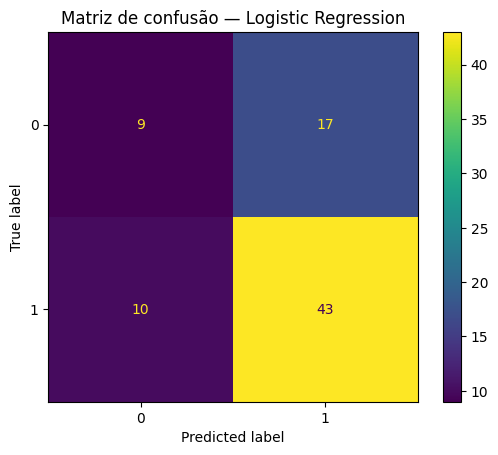

In [14]:
metrics_lr = evaluate_model(log_reg, X_test, y_test, title="Logistic Regression")


=== Random Forest ===
              precision    recall  f1-score   support

           0      0.556     0.192     0.286        26
           1      0.700     0.925     0.797        53

    accuracy                          0.684        79
   macro avg      0.628     0.558     0.541        79
weighted avg      0.652     0.684     0.629        79

ROC-AUC: 0.6473


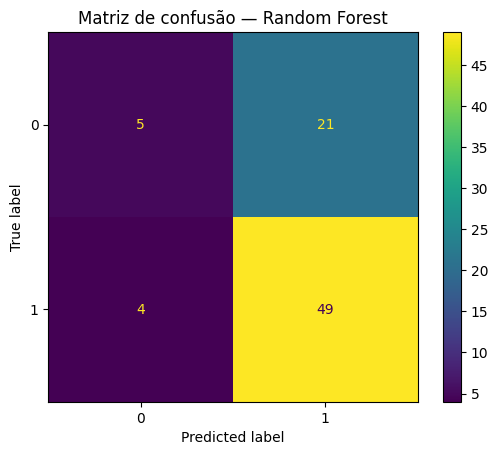

In [15]:
metrics_rf = evaluate_model(rf, X_test, y_test, title="Random Forest")

## 7. Comparação dos modelos

Vamos comparar os modelos pela métrica ROC-AUC.


In [16]:
pd.DataFrame([metrics_lr, metrics_rf]).sort_values("roc_auc", ascending=False)

,model,roc_auc
1,Random Forest,0.647315
0,Logistic Regression,0.588534


## 8. Interpretação (Logistic Regression)

A regressão logística é interpretável: seus coeficientes indicam direção de associação com a classe positiva (aprovação).

Como usamos One-Hot Encoding, teremos diversas features expandidas.  
Vamos extrair os nomes finais das features e ranquear os coeficientes.


In [17]:
# Pegando o preprocessor já treinado
pre = log_reg.named_steps["preprocess"]
model = log_reg.named_steps["model"]

# Feature names após one-hot
ohe = pre.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_feature_names])

coefs = model.coef_.ravel()
coef_df = pd.DataFrame({"feature": all_feature_names, "coef": coefs})

coef_df.sort_values("coef", ascending=False).head(15)


,feature,coef
24,Mjob_health,0.643446
26,Mjob_services,0.529049
10,Walc,0.483703
40,schoolsup_no,0.476243
51,higher_yes,0.441032
37,guardian_father,0.376318
32,Fjob_teacher,0.353063
21,Pstatus_A,0.297361
48,nursery_no,0.259184
52,internet_no,0.243296


In [18]:
coef_df.sort_values("coef", ascending=True).head(15)

,feature,coef
5,failures,-0.959695
27,Mjob_teacher,-0.870316
8,goout,-0.502784
41,schoolsup_yes,-0.476083
50,higher_no,-0.440873
25,Mjob_other,-0.360061
22,Pstatus_T,-0.297201
39,guardian_other,-0.286288
49,nursery_yes,-0.259024
29,Fjob_health,-0.243268


## 9. Interpretação (Random Forest)

Para Random Forest, olhamos importâncias de features.

Observação:
- Importância não indica direção (só relevância).
- Como há One-Hot Encoding, também teremos muitas features.


In [19]:
pre_rf = rf.named_steps["preprocess"]
model_rf = rf.named_steps["model"]

ohe_rf = pre_rf.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names_rf = ohe_rf.get_feature_names_out(categorical_features)
all_feature_names_rf = np.concatenate([numeric_features, cat_feature_names_rf])

importances = model_rf.feature_importances_
imp_df = pd.DataFrame({"feature": all_feature_names_rf, "importance": importances})

imp_df.sort_values("importance", ascending=False).head(20)


,feature,importance
12,absences,0.075375
5,failures,0.074174
8,goout,0.046246
0,age,0.043523
11,health,0.037908
7,freetime,0.034499
10,Walc,0.034375
1,Medu,0.033000
6,famrel,0.032622
2,Fedu,0.032524


## 10. Síntese final

### O que foi feito
- Criamos um target binário `target_pass` com base em `G3 >= 10`
- Excluímos `G1`, `G2`, `G3` das features para evitar vazamento
- Treinamos dois modelos baseline:
  - Logistic Regression
  - Random Forest
- Avaliamos com:
  - Classification report
  - Matriz de confusão
  - ROC-AUC e curva ROC
- Extraímos interpretação:
  - coeficientes (LogReg)
  - importâncias (RF)

### Resultados observados (preencher após rodar)
- ROC-AUC Logistic Regression: ...
- ROC-AUC Random Forest: ...
- Principais features associadas à aprovação: ...
- Principais features associadas à reprovação: ...

### Próximos passos recomendados
- Validação cruzada (cross-validation)
- Ajuste de hiperparâmetros (GridSearch/RandomSearch)
- Métricas focadas por classe (ex: recall da classe reprovado)
- Técnicas de balanceamento (se necessário)
- Explicabilidade mais robusta (SHAP)
- Criar uma versão "feature store" / pipeline reprodutível (se for para produção)


In [20]:
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

# escolha qual modelo salvar (ex: Random Forest)
MODEL_PATH = ARTIFACTS_DIR / "model_baseline_rf.joblib"

joblib.dump(rf, MODEL_PATH)

print(f"Modelo salvo em: {MODEL_PATH.resolve()}")

Modelo salvo em: /home/alexandre/adk_experiments/desafio_tecnico_ml/artifacts/model_baseline_rf.joblib


# Teste predict

In [21]:
model = joblib.load("artifacts/model_baseline_rf.joblib")

In [22]:
X_novo = X.iloc[[0]].copy()

X_novo


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6


In [24]:
X_novo["studytime"] = 3
X_novo["failures"] = 0
X_novo["absences"] = 2
X_novo["internet"] = "yes"
X_novo["schoolsup"] = "no"


In [25]:
model.predict(X_novo)
model.predict_proba(X_novo)


array([[0.35, 0.65]])

## Síntese do Modelo Baseline

Este notebook construiu um **modelo baseline de classificação binária** para prever a **aprovação de um aluno** com base em
características socioeconômicas, familiares e comportamentais.

### Definição do target
Foi criada a variável `target_pass`:
- `target_pass = 1` → aluno **aprovado** (`G3 >= 10`)
- `target_pass = 0` → aluno **reprovado** (`G3 < 10`)

A classe positiva do modelo é **1 (aprovado)**.

### Dados utilizados pelo modelo
O modelo utiliza apenas variáveis de contexto e comportamento, **excluindo** as notas:
- `G1`, `G2`, `G3` (evitam vazamento de informação)

O pipeline inclui:
- imputação de valores ausentes
- padronização de variáveis numéricas
- codificação One-Hot de variáveis categóricas

### Modelo treinado
Foi treinado um modelo **Random Forest Classifier**, encapsulado em um pipeline de pré-processamento,
e salvo no arquivo:




### Interpretação da saída
- `model.predict(X_novo)` retorna a **classe prevista**:
  - `0` → reprovado
  - `1` → aprovado

- `model.predict_proba(X_novo)` retorna as **probabilidades por classe**, na ordem:
  - índice `0` → probabilidade de reprovação
  - índice `1` → probabilidade de aprovação

Exemplo:


Indica 35% de chance de reprovação e 65% de chance de aprovação.

### Observação
Este modelo é um **baseline**, com foco em simplicidade, interpretabilidade e reprodutibilidade.
Os resultados não devem ser interpretados como predição causal, mas como **estimativa probabilística**
baseada em padrões históricos do dataset.
